# ColPali

This notebook shows cases ColPali with SmolVLM

## Create model

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from brag import embed, retrieve
import os

import torch

from pdf2image import convert_from_path
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm

from colpali_engine.models import (
    ColQwen2,
    ColQwen2Processor,
    ColIdefics3,
    ColIdefics3Processor,
)

/home/zuppif/Documents/lazy-rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = ColIdefics3.from_pretrained(
    "vidore/colsmolvlm-alpha",
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
    # attn_implementation="flash_attention_2",  # or eager
).eval()
processor = ColIdefics3Processor.from_pretrained("vidore/colsmolvlm-alpha")

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]
Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


### Loading a pdf as image

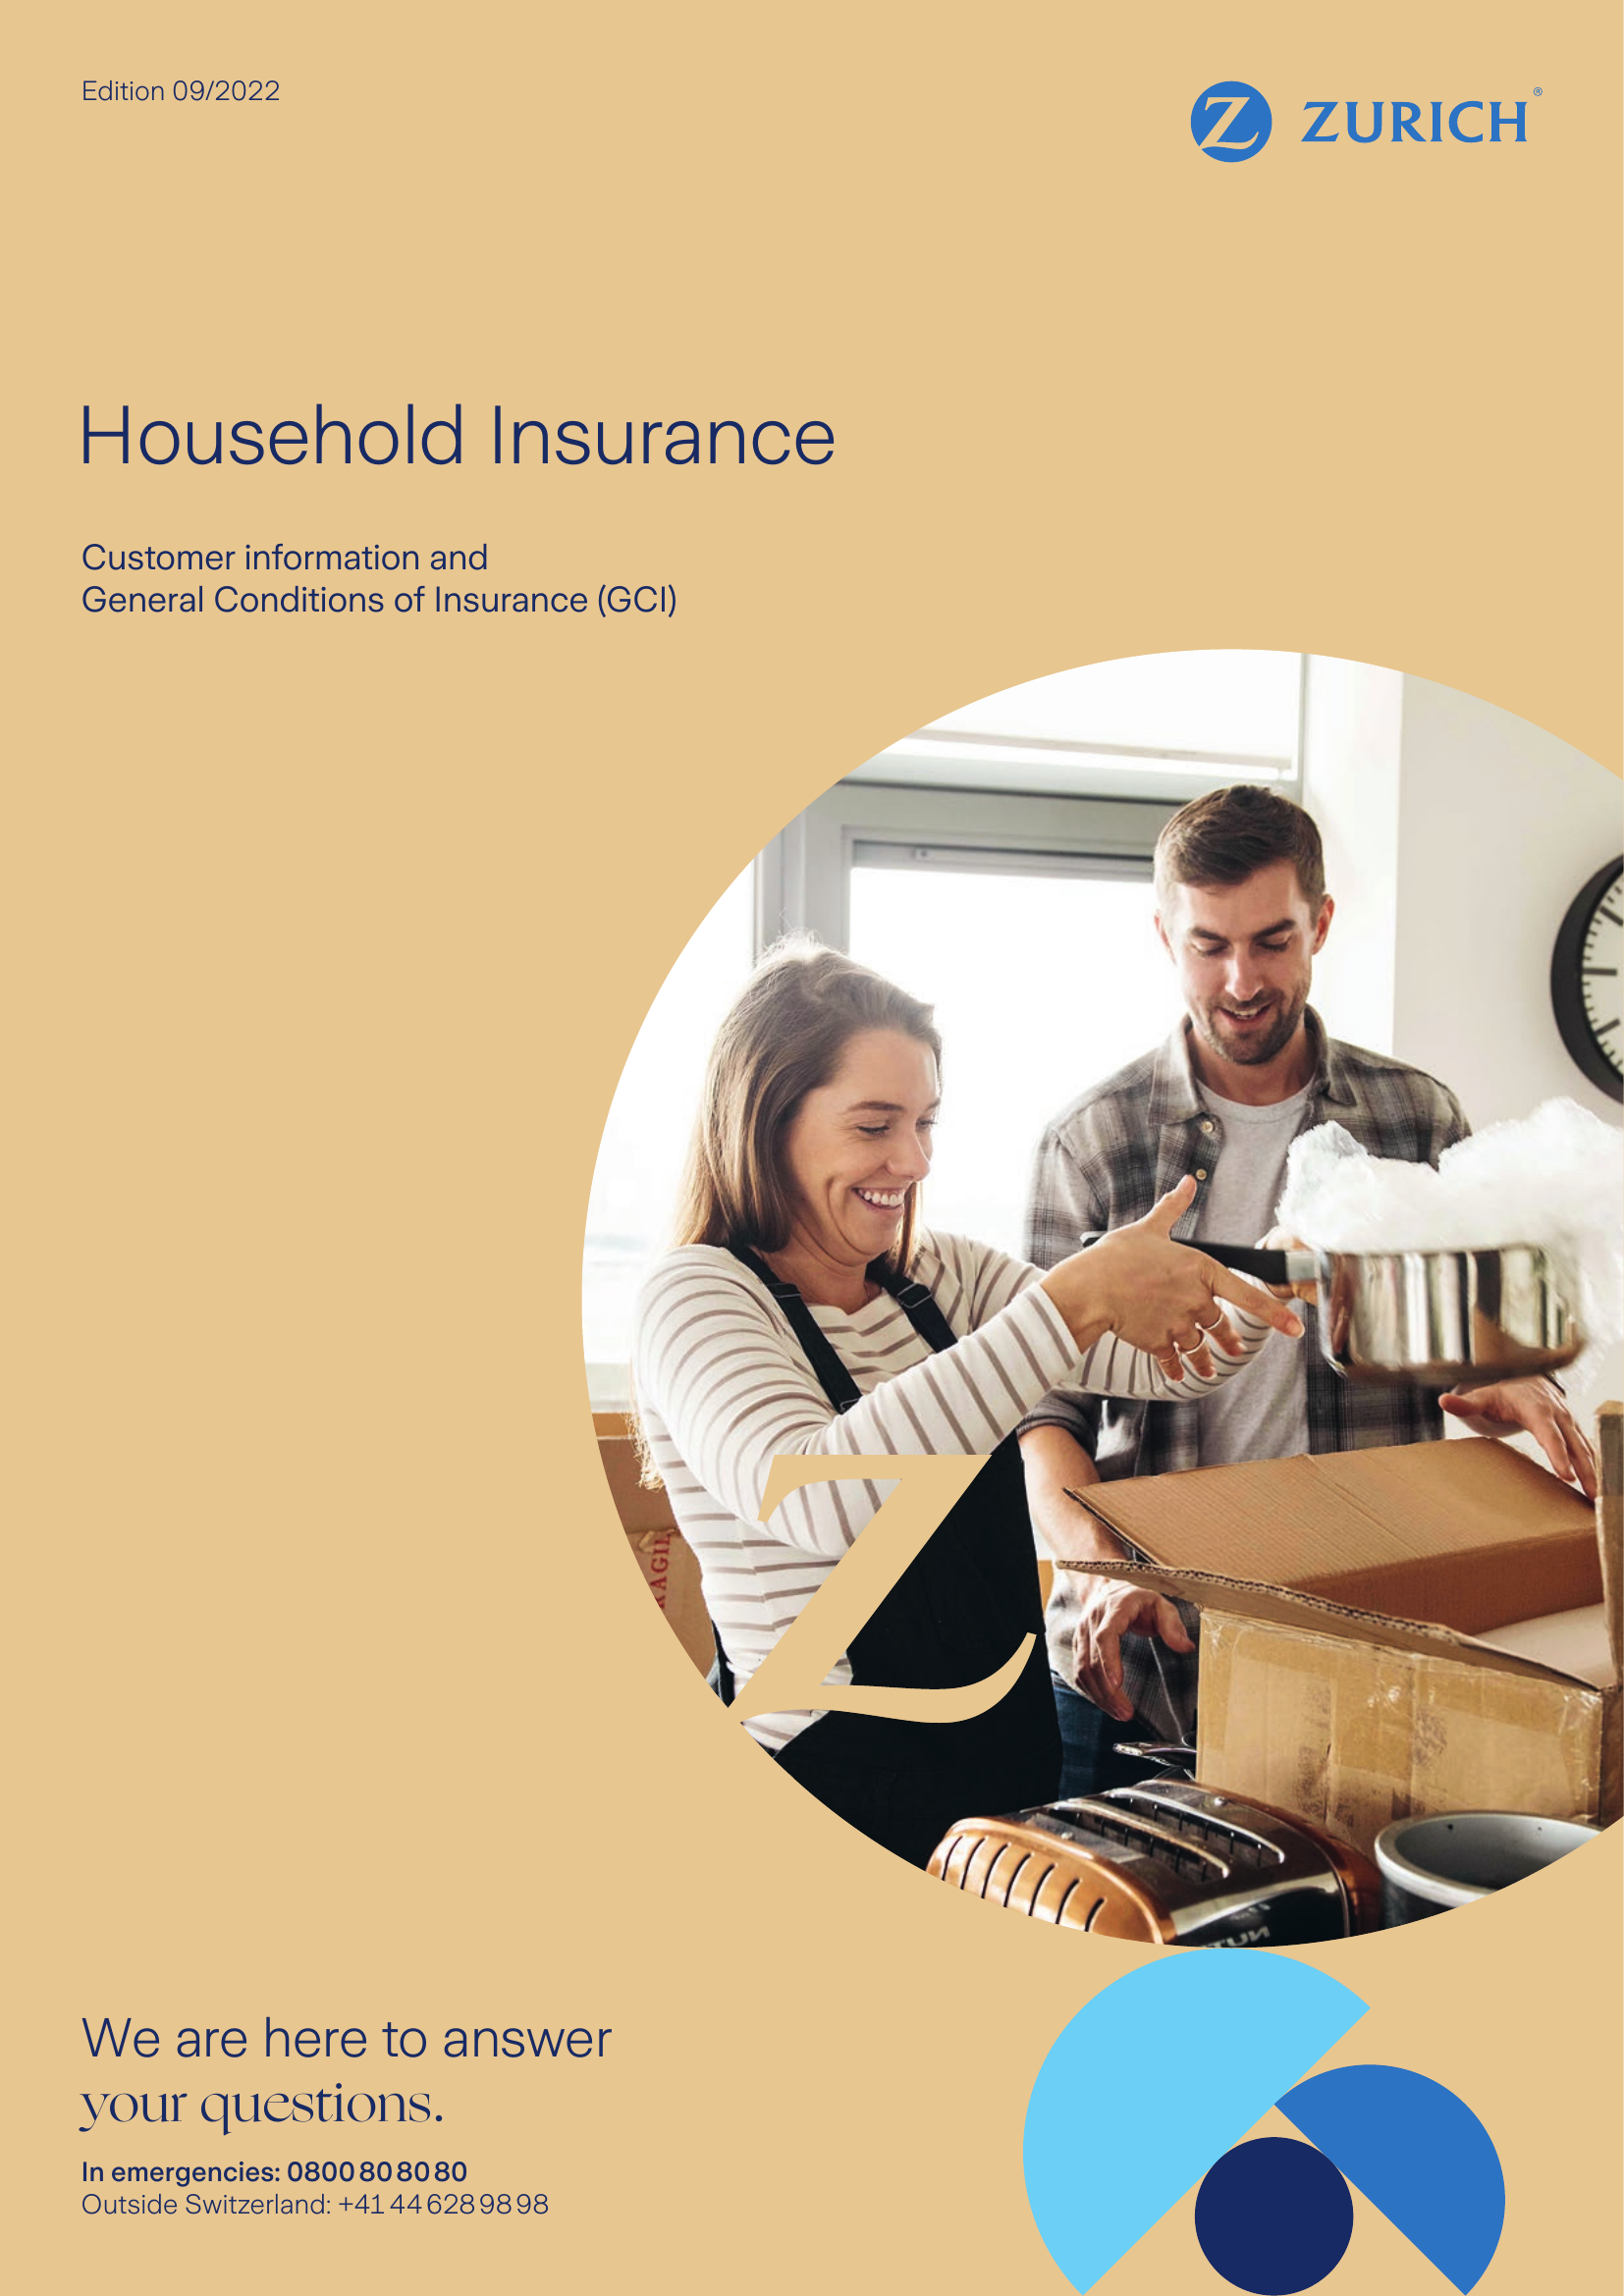

In [4]:
file_path = "../boring_insurance.pdf"
images = convert_from_path(file_path, thread_count=4)
images[0]

## Embed the document

In [5]:
embeddings, images = embed(model, processor, "../boring_insurance.pdf")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:28<00:00,  1.83it/s]


## Retrieve pages

In [22]:
query = "What is the minimum I will get paid and for which reason?"
k = 4

results = retrieve(model, processor, query, embeddings, images, k)[0]

tensor([[ 7.8125,  7.4375,  7.3750,  7.3125],
        [ 9.0625,  8.6250,  8.4375,  8.4375],
        [ 9.0000,  9.0000,  8.9375,  8.9375],
        [ 8.3125,  8.0625,  8.0625,  8.0000],
        [10.5625, 10.3125, 10.1875, 10.1250],
        [ 8.9375,  8.7500,  8.5000,  8.5000],
        [ 8.1250,  7.9062,  7.6250,  7.5625],
        [10.5625, 10.3125, 10.1875, 10.1250],
        [ 8.3125,  8.0625,  8.0625,  8.0000],
        [ 9.0625,  8.6250,  8.4375,  8.4375],
        [ 9.4375,  9.1875,  8.6250,  8.5000],
        [10.5625, 10.3125, 10.1875, 10.1250],
        [ 8.3750,  8.2500,  8.1250,  7.7812],
        [ 8.9375,  8.7500,  8.5000,  8.5000],
        [ 8.6875,  8.6250,  7.7188,  7.7188],
        [ 8.9375,  8.7500,  8.5000,  8.5000],
        [ 8.3750,  8.2500,  8.1250,  7.7812],
        [ 7.7188,  7.5312,  7.4062,  7.3750],
        [ 8.3750,  8.2500,  8.1250,  7.7812],
        [10.5625, 10.3125, 10.1875, 10.1250],
        [10.6875, 10.6250, 10.6250, 10.5000],
        [10.5625, 10.3125, 10.1875

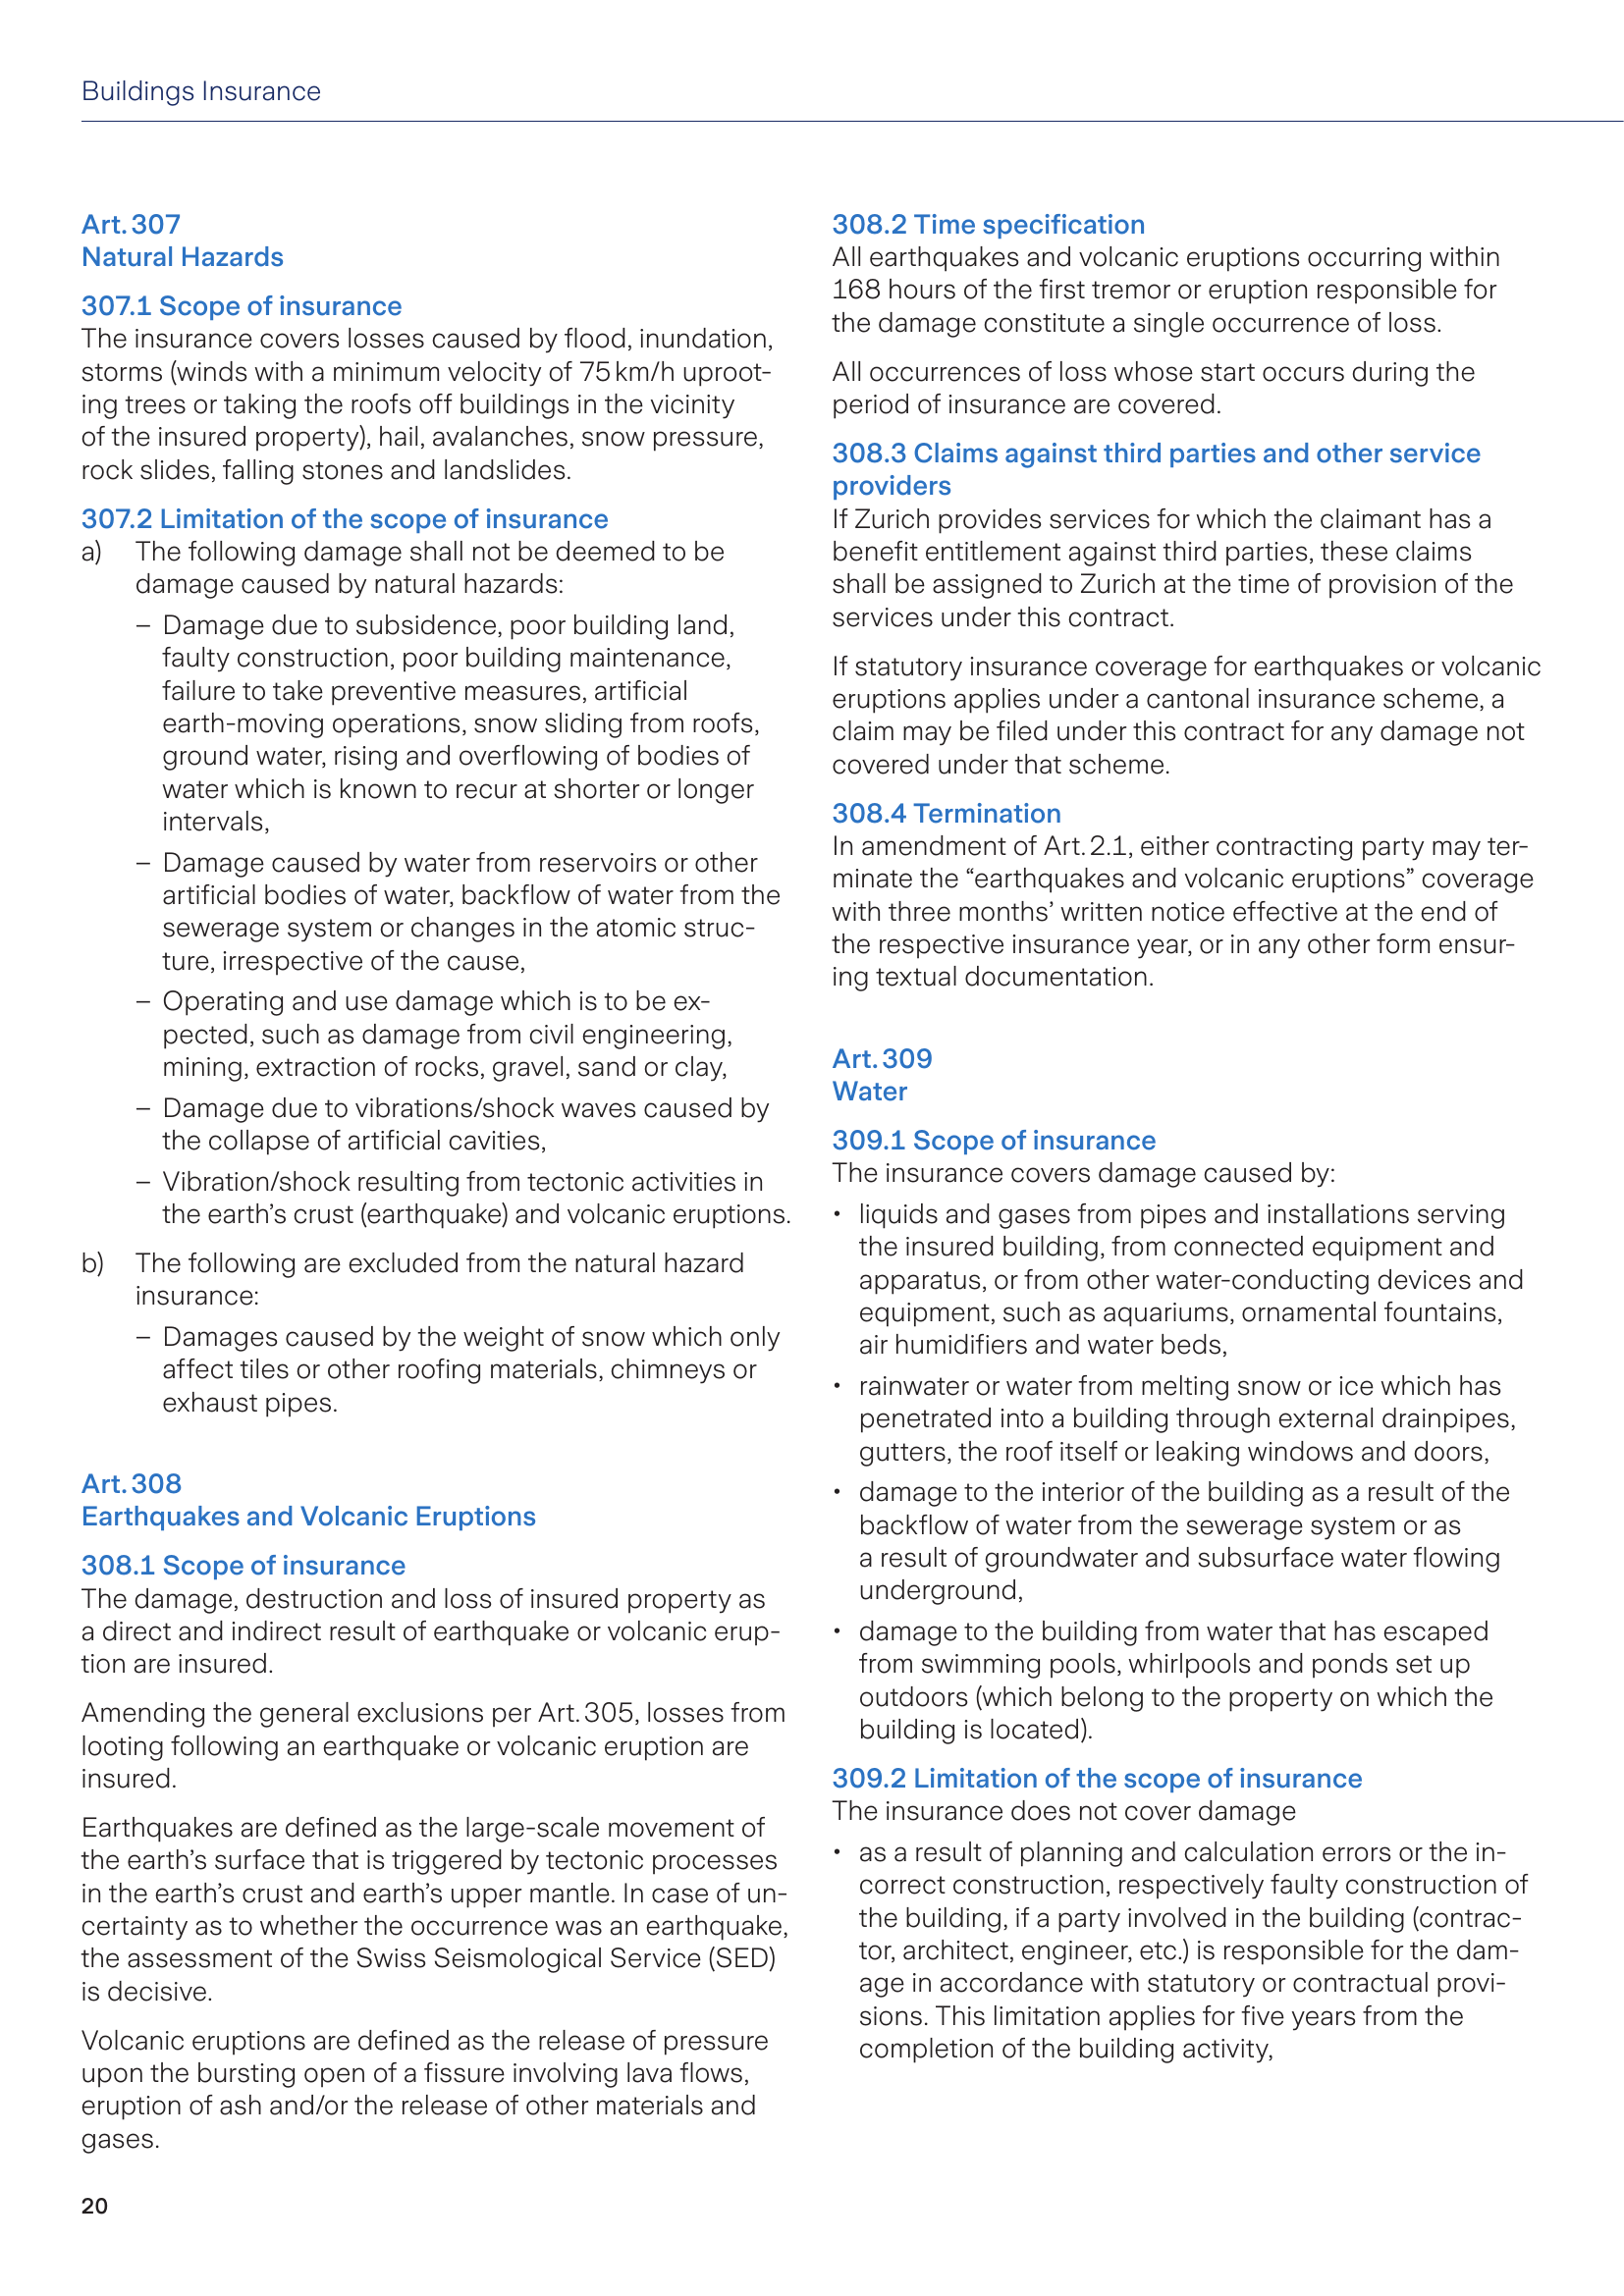

In [23]:
results[0][0]

In [24]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

llm_processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
llm_model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16,
).to(DEVICE)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [25]:
from PIL import Image
from transformers.image_utils import load_image

SYSTEM_PROMPT = """You ANSWER a QUERY given the context provide in the images.

You think step by step beforing answering, you look at all the images. 

You provide reasoning on your answer

QUERY: {query}
"""

messages = [
    {
        "role": "user",
        "content": [
            *[{"type": "image"} for _ in range(k)],
            {"type": "text", "text": SYSTEM_PROMPT.format(query=query)},
        ],
    },
]

print(messages)

# Prepare inputs
prompt = llm_processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = llm_processor(text=prompt, images=[res[0] for res in results], return_tensors="pt")
inputs = inputs.to(DEVICE)

[{'role': 'user', 'content': [{'type': 'image'}, {'type': 'image'}, {'type': 'image'}, {'type': 'image'}, {'type': 'text', 'text': 'You ANSWER a QUERY given the context provide in the images.\n\nYou think step by step beforing answering, you look at all the images. \n\nYou provide reasoning on your answer\n\nQUERY: What is the minimum I will get paid and for which reason?\n'}]}]


In [26]:
# Generate outputs
generated_ids = llm_model.generate(**inputs, max_new_tokens=500)
generated_texts = llm_processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

User:<image>You ANSWER a QUERY given the context provide in the images.

You think step by step beforing answering, you look at all the images. 

You provide reasoning on your answer

QUERY: What is the minimum I will get paid and for which reason?

Assistant: 20% of the sum insured.
